 # Spatial Correlation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
import pickle
import time

np.random.seed(19)
DATA_DIR = 'data/'
PICKLE_DIR = 'pickles/'
DAYS_TO_MINUTES = 24*60
DATA_TYPES = {'CPU', 'MEM'}
SAMPLE_SIZE = 1250


In [2]:
DATA = dict()
SAMPLES = dict()


In [3]:
for data_type in DATA_TYPES:
    if data_type not in DATA:
        DATA[data_type] = np.load(DATA_DIR + data_type + '.npy')
        np.random.shuffle(DATA[data_type])

second_data_type = None
for first_data_type in DATA:
    if second_data_type is not None:
        assert DATA[first_data_type].shape == DATA[second_data_type].shape
    second_data_type = first_data_type

assert second_data_type is not None
NO_OF_MACHINES = DATA[second_data_type].shape[0]
NO_OF_TIMESTAMPS = DATA[second_data_type].shape[1]

for data_type in DATA:
    SAMPLES[data_type] = DATA[data_type][:SAMPLE_SIZE]


In [4]:
def ccf(x, y, no_lag=False):
    '''Normalized cross-correlation function,
    similar to ccf in the R language.

    Parameters:
    x -- first time series
    y --  second time series

    Optional:
    no_lag -- False by default. If true, return a list with every time-shift
        possible instead.

    Returns:
        A float with 0 time-shift or a list of floats that represent the
        cross-correlation for every possible time-shift.
    '''
    if np.std(y) * np.std(x) == 0:
        return 0
    else:
        correlation = (
            np.correlate(y - np.mean(y), x - np.mean(x))
            if no_lag else ss.correlate(y - np.mean(y), x - np.mean(x)))
        return correlation / (np.std(y) * np.std(x) * len(y))


In [5]:
class TwoCorrelationWindows(object):
    def __init__(self):
        self.first = dict()
        self.second = dict()
        self.full = np.full((SAMPLE_SIZE, SAMPLE_SIZE-1), np.nan)


In [6]:
try:
    pickle_in = open(PICKLE_DIR + "spatial_correlations.pickle","rb")
    SPATIAL_CORRELATIONS = pickle.load(pickle_in)
except FileNotFoundError:
    CPU_SPATIAL_CORRELATIONS = TwoCorrelationWindows()
    MEM_SPATIAL_CORRELATIONS = TwoCorrelationWindows()
    SPATIAL_CORRELATIONS = {
        'CPU': CPU_SPATIAL_CORRELATIONS, 'MEM': MEM_SPATIAL_CORRELATIONS}


 Calculate the spatial correlation between every possible pair of machines
 in our subsample. Do not include any time-shift. Do not include a machine's
 correlation with itself (by definition this will be 1).

In [7]:
for i in range(SAMPLE_SIZE):
    for j in range(SAMPLE_SIZE):
        if i < j:
            for data_type in DATA_TYPES:
                if np.isnan(
                    (SPATIAL_CORRELATIONS[data_type].full)[i, j-1]):

                    machine_x = SAMPLES[data_type][i]
                    machine_y = SAMPLES[data_type][j]
                    (SPATIAL_CORRELATIONS[data_type].full)[i, j-1] = ccf(
                        machine_x, machine_y, no_lag=True)
                    (SPATIAL_CORRELATIONS[data_type].full)[j, i] = (
                        SPATIAL_CORRELATIONS[data_type].full)[i, j-1]

pickle_out = open(PICKLE_DIR + "spatial_correlations.pickle","wb")
pickle.dump(SPATIAL_CORRELATIONS, pickle_out)
pickle_out.close()


 Have a look at how high the spatial correlation values seem to be.

CPU Maximum: 0.9360539397875777
CPU Minimum: -0.6097779583987322
CPU Average: 0.31695470997199626
MEM Maximum: 0.9309632468133553
MEM Minimum: -0.8696172491680104
MEM Average: 0.1673465413924906


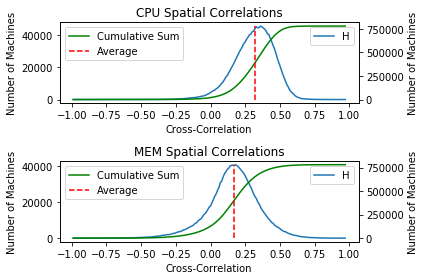

In [17]:
i = 1
for data_type in SPATIAL_CORRELATIONS:
    corr = SPATIAL_CORRELATIONS[data_type].full
    abs_correlations = np.abs(corr)
    print(data_type, 'Maximum:', np.amax(corr))
    print(data_type, 'Minimum:', np.amin(corr))
    print(data_type, 'Average:', np.average(corr))
    values, base = np.histogram(corr, bins=[n/100 for n in range(-99, 99)])

    ax0 = plt.subplot(len(SPATIAL_CORRELATIONS), 1, i)
    ax0.plot(base[:-1], values, '-', label='Histogram')
    plt.xlabel('Cross-Correlation')
    plt.ylabel('Number of Machines')
    plt.legend('Histogram')
    ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
    ax1.plot(base[:-1], np.cumsum(values)//2, 'g-', label='Cumulative Sum')
    ax1.plot(2*[np.average(corr)], [0, corr.shape[0]*corr.shape[1]//2], 'r--', label='Average')
    plt.ylabel('Number of Machines')
    plt.xticks([n/4 for n in range(-4, 5)])
    plt.title(data_type + ' Spatial Correlations')
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()


 They are quite low and insignificant. Let us evaluate whether machine pairs
 with a high-cross correlation maintain their correlation. Let us also
 investigate cross-correlations in a wide range of durations.

In [18]:
def calculate_correlations(time_windows, overwrite=False):
    start = time.process_time()
    for window in time_windows:
        for machine_one in range(SAMPLE_SIZE):
            for machine_two in range(SAMPLE_SIZE):
                #If the first and second machine are the same one, skip.
                if machine_one < machine_two:
                    for data_type in SAMPLES:
                        def calc_first_window(
                            data_type, window, machine_one, machine_two):
                            machine_x = SAMPLES[data_type][machine_one][
                                NO_OF_TIMESTAMPS // 2 - window :
                                NO_OF_TIMESTAMPS // 2]
                            machine_y = SAMPLES[data_type][machine_two][
                                NO_OF_TIMESTAMPS // 2 - window :
                                NO_OF_TIMESTAMPS // 2]

                            (SPATIAL_CORRELATIONS[data_type].first
                            )[window][machine_one, machine_two - 1] = ccf(
                                machine_x, machine_y, no_lag=True)

                            (SPATIAL_CORRELATIONS[data_type].first
                            )[window][machine_two, machine_one] = (
                                SPATIAL_CORRELATIONS[data_type].first
                                )[window][machine_one, machine_two - 1]
                        try:
                            if overwrite or np.isnan(
                                (SPATIAL_CORRELATIONS[data_type].first
                                )[window][machine_one, machine_two - 1]):

                                calc_first_window(data_type, window,
                                                  machine_one, machine_two)
                        except KeyError:
                            (SPATIAL_CORRELATIONS[data_type].first
                            )[window] = np.full(
                                (SAMPLE_SIZE, SAMPLE_SIZE-1),
                                np.nan)

                            calc_first_window(data_type, window,
                                              machine_one, machine_two)


                        def calc_second_window(
                            data_type, window, machine_one, machine_two):
                            machine_x = SAMPLES[data_type][machine_one][
                                NO_OF_TIMESTAMPS // 2 :
                                NO_OF_TIMESTAMPS // 2 + window]
                            machine_y = SAMPLES[data_type][machine_two][
                                NO_OF_TIMESTAMPS // 2 :
                                NO_OF_TIMESTAMPS // 2 + window]

                            (SPATIAL_CORRELATIONS[data_type].second
                            )[window][machine_one, machine_two - 1] = ccf(
                                machine_x, machine_y, no_lag=True)

                            (SPATIAL_CORRELATIONS[data_type].second
                            )[window][machine_two, machine_one] = (
                                SPATIAL_CORRELATIONS[data_type].second
                                )[window][machine_one, machine_two - 1]
                        try:
                            if not overwrite or np.isnan(
                                (SPATIAL_CORRELATIONS[data_type].second
                                )[window][machine_one, machine_two - 1]):

                                calc_second_window(data_type, window,
                                                   machine_one, machine_two)
                        except KeyError:
                            (SPATIAL_CORRELATIONS[data_type].second
                            )[window] = np.full(
                                (SAMPLE_SIZE, SAMPLE_SIZE-1),
                                np.nan)

                            calc_second_window(data_type, window,
                                               machine_one, machine_two)

            machine_one += 1
    elapsed_time = time.process_time() - start
    print('Amount of time taken to calculate correlations:',
          elapsed_time, 'seconds')

    try:
        if not overwrite:
            pickle_in = open(PICKLE_DIR + "spatial_correlations.pickle","rb")
            spatial_corrs = pickle.load(pickle_in)
            for data_type in SPATIAL_CORRELATIONS:
                SPATIAL_CORRELATIONS[data_type].first = {
                    **spatial_corrs[data_type].first,
                    **SPATIAL_CORRELATIONS[data_type].first}
                SPATIAL_CORRELATIONS[data_type].second = {
                    **spatial_corrs[data_type].second,
                    **SPATIAL_CORRELATIONS[data_type].second}
    except FileNotFoundError:
        pass
    finally:
        pickle_out = open(PICKLE_DIR + "spatial_correlations.pickle","wb")
        pickle.dump(SPATIAL_CORRELATIONS, pickle_out)
        pickle_out.close()


In [32]:
def plot_corr_drift(time_windows):
    for window in time_windows:
        print(window)
        i = 1
        for data_type in SPATIAL_CORRELATIONS:
            corr = SPATIAL_CORRELATIONS[data_type]
            avg = np.average((corr.first)[window[0]])
            high_corr1 = (corr.first)[window[0]][(corr.first)[window[0]] > avg]
            high_corr2 = (corr.second)[window[1]][(corr.first)[window[0]] > avg]
            high_corr = high_corr2 - high_corr1

            corr1 = (corr.first)[window[0]]
            corr2 = (corr.second)[window[1]]
            corr = corr2 - corr1
            abs_correlations = np.abs(corr)
            values1, base = np.histogram(high_corr1,
                                         bins=[n/100 for n in range(-85, 99)])
            values2, base = np.histogram(high_corr2,
                                         bins=[n/100 for n in range(-85, 99)])
            values, base = np.histogram(high_corr,
                                        bins=[n/100 for n in range(-85, 99)])

            ax0 = plt.subplot(len(SPATIAL_CORRELATIONS), 1, i)
            ax0.plot(base[:-1], values1, 'g-',
                     base[:-1], values2, 'y-',
                     base[:-1], values, 'r-')
            plt.xlabel('Cross-Correlation')
            plt.ylabel('Number of Machines')
            ax1 = ax0.twinx()  # instantiate a second axes that shares the same x-axis
            ax1.plot(base[:-1], np.cumsum(values1)//2, 'g-',
                     base[:-1], np.cumsum(values2)//2, 'y-',
                     base[:-1], np.cumsum(values)//2, 'r-',
                     2*[np.average(high_corr1)],
                     [0, SAMPLE_SIZE*(SAMPLE_SIZE-1)//2//2], 'g--',
                     2*[np.average(high_corr2)],
                     [0, SAMPLE_SIZE*(SAMPLE_SIZE-1)//2//2], 'y--',
                     2*[np.average(high_corr)],
                     [0, SAMPLE_SIZE*(SAMPLE_SIZE-1)//2//2], 'r--')
            plt.xticks([n/4 for n in range (-2, 4)])
            plt.ylabel('Number of Machines')
            plt.title(data_type + ' Spatial Correlation Drift')
            i += 1
            print(np.average(high_corr1), np.average(high_corr2), np.average(high_corr))

        plt.tight_layout()
        plt.show()


In [20]:
time_windows_one = [14*DAYS_TO_MINUTES//5, 7*DAYS_TO_MINUTES//5,
                 1*DAYS_TO_MINUTES//5, int(0.5*DAYS_TO_MINUTES//5)]


In [21]:
calculate_correlations(time_windows_one)


KeyboardInterrupt: 

In [24]:
time_windows_two = [
    2*[14*DAYS_TO_MINUTES//5],
    2*[7*DAYS_TO_MINUTES//5],
    2*[1*DAYS_TO_MINUTES//5],
    2*[int(0.5*DAYS_TO_MINUTES//5)],
    [14*DAYS_TO_MINUTES//5, int(0.5*DAYS_TO_MINUTES//5)],
]


[4032, 4032]
0.22586848631752163 0.38263305042990414 0.15676456411238257
0.21247931800280412 0.07331360918706374 -0.13916570881574042


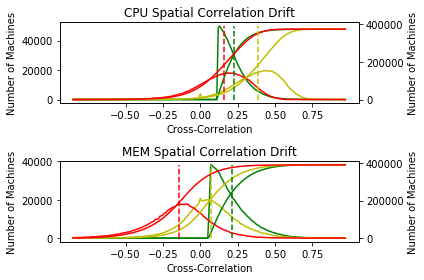

[2016, 2016]
0.2685859042057786 0.19782974470250037 -0.07075615950327814
0.2195214049563501 0.07912039479490286 -0.14040101016144724


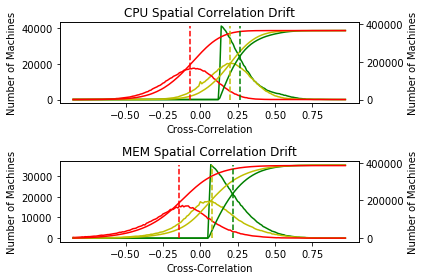

[288, 288]
0.22848778780635576 0.13332134577046922 -0.0951664420358867
0.23026377797739436 0.05759508714664595 -0.17266869083074837


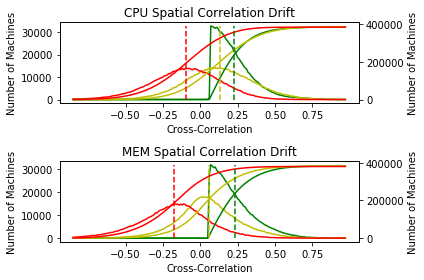

[144, 144]
0.29074677999366827 0.09172605534572083 -0.19902072464794734
0.30059288887528723 0.06144039636584834 -0.23915249250943899


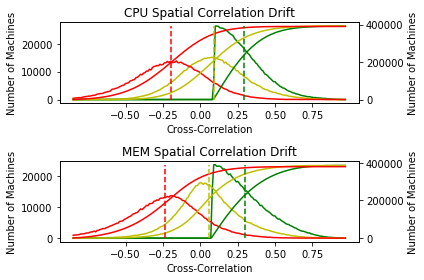

[4032, 144]
0.22586848631752163 0.08681855153440357 -0.139049934783118
0.21247931800280412 0.062426861497040236 -0.150052456505764


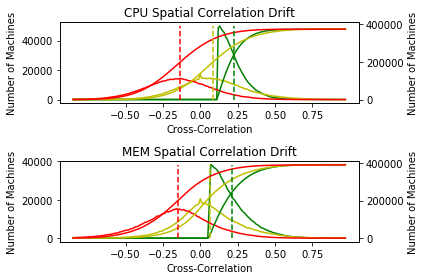

In [33]:
plot_corr_drift(time_windows_two)


 There is no significant level of spatial correlation in any timeframe. Let us
 discard mforecasting methods that rely on it.

In [23]:
SPATIAL_CORRELATIONS['CPU'].first.keys()

dict_keys([4032, 2016, 288, 144])